In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Import data and train model

In [3]:
from mnist import MNIST

mnist = MNIST('MNIST')

x_train, y_train = mnist.load_training() # 60000 samples
x_test, y_test = mnist.load_testing() # 10000 samples

# Convert to ndarrays and enforce type
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

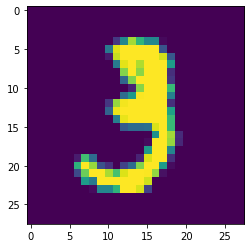

In [4]:
plt.imshow(x_train[10].reshape(28, 28));

In [5]:
# %timeit -r 10 knn.fit(x_train, y_train)
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import time


def knn_timed_fit(x_train, y_train, n_attempts=1, K=10):
    knn = KNeighborsClassifier(n_neighbors=K, n_jobs=-1, metric='euclidean')
    
    times = []
    for _ in tqdm(range(n_attempts)):
        t0 = time.time()
        knn.fit(x_train, y_train)
        times.append(time.time() - t0)
        
    print('K-NN: n={} fits resulted in a mean fit time of {}s'.format(
        n_attempts, np.mean(np.array(times))))
    
    return knn

In [6]:
knn = knn_timed_fit(x_train, y_train, n_attempts=3)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:04<00:00, 101.59s/it]


K-NN: n=3 fits resulted in a mean fit time of 101.58497174580891s


### Evaluate model

In [7]:
y_pred = knn.predict(x_test[:1000]) # > do in batches

#### Show some misclassified numbers  
Part of ex. 1a

Actual number: 4 
Predicted number: 0


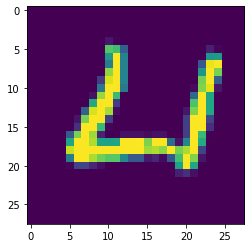

Actual number: 2 
Predicted number: 1


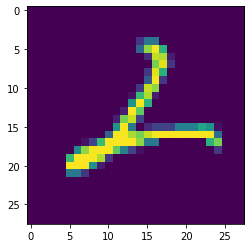

Actual number: 8 
Predicted number: 2


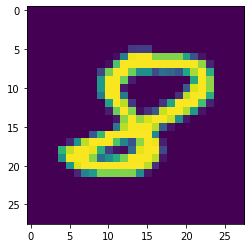

Actual number: 2 
Predicted number: 7


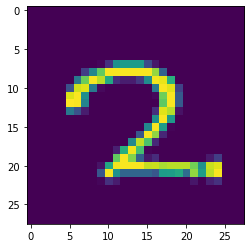

Actual number: 4 
Predicted number: 9


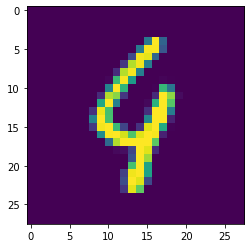

In [8]:
bins = [1 if i == j else 0 for i, j in zip(y_pred, y_test[:1000])]
fail_idxs = [i for i in range(len(bins)) if bins[i] == 0]
max_n = 5

# 1b
for n, idx in enumerate(fail_idxs):
    if n >= max_n:
        break
    print('Actual number:', y_test[idx], '\nPredicted number:', y_pred[idx])
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.show()

#### Confusion matrix and error rates  
Part of ex. 1a

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        85
           1       0.94      1.00      0.97       126
           2       0.99      0.90      0.94       116
           3       0.96      0.94      0.95       107
           4       0.96      0.92      0.94       110
           5       0.98      0.98      0.98        87
           6       0.98      0.97      0.97        87
           7       0.92      0.97      0.95        99
           8       0.98      0.91      0.94        89
           9       0.91      0.97      0.94        94

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



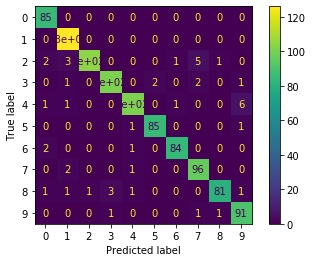

In [9]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


def evaluation_report(knn, x, y_true, y_pred):
    """Find the confusion matrix and the error rate for the NN classifier.
    
    Params:
        knn: sklearn.neighbors.KNeighborsClassifier instance
        x: np.ndarray
            feature vectors
        y_true: np.ndarray
            True target values
        y_pred: np.ndarray
            Predicted target values
    """
    print(classification_report(y_true, y_pred))

    plot_confusion_matrix(
        knn, x, y_true, 
        display_labels=[i for i in range(10)],
        normalize=None
    );
    
    
evaluation_report(knn, x_test[:1000], y_test[:1000], y_pred)

### Exercise 2

In [19]:
def get_class_members(y, x):
    """Place all x members of a y class into a dict
    
    Params:
        x: np.ndarray
            Feature vectors
        y: np.ndarray
            True target values
    Returns:
        class_members: dict
            Format: {1: [np.ndarray, ...], 2:...}
    """
    class_members = {}
    # Initialize class member vector lists
    for class_ in np.unique(np.array(y_test)): # aka set
        class_members[class_] = []
    # Put vectors in corresponding baskets
    for class_, vector in zip(y, x):
        class_members[class_].append(vector)
    return class_members


class_members = get_class_members(y_train, x_train)

In [20]:
from sklearn.cluster import KMeans


def get_template_class_members(class_members, n_templates=64, show_progress=True):
    """Condense x, y set into n_templates classes using class-wise K-means clustering.
    K-means cluster centroids act as template vectors.
    
    Params:
        class_members: dict
            Format: {1: [np.ndarray, ...], 2:...}
        n_templates: int
            Amount of template images per MNIST integer
        show_progress: bool
            Show progress bar toggle
    Returns:
        template_class_members: dict
            Condensed version of class_members parameter.
            Format: {1: [np.ndarray, ...], 2:...}
    """
    kmeans = KMeans(n_clusters=n_templates, verbose=1, n_jobs=-1)
    # Wrap iterator in tqdm progress indicator
    if show_progress:
        class_items = tqdm(class_members.items())
    else:
        class_items = class_members.items()
    # Cluster classes into fewer template classes
    template_class_members = {}
    for class_, members in class_items:
        class_kmeans = kmeans.fit(members)
        template_vectors = class_kmeans.cluster_centers_
        template_class_members[class_] = template_vectors
    return template_class_members


template_class_members = get_template_class_members(class_members)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [18:33<00:00, 111.30s/it]


#### Train the KNN with the template classes  
Notice greatly reduced training time.

In [21]:
# Flatten training data to fit x, y format
template_x, template_y = [], []
for class_, template_vectors in template_class_members.items():
    template_y.extend([class_]*len(template_vectors))
    template_x.extend(template_vectors)

small_knn = knn_timed_fit(template_x, template_y, n_attempts=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.93it/s]


K-NN: n=10 fits resulted in a mean fit time of 0.1663965940475464s


              precision    recall  f1-score   support

           0       0.93      0.94      0.94        85
           1       0.93      1.00      0.96       126
           2       0.95      0.85      0.90       116
           3       0.90      0.93      0.91       107
           4       0.92      0.88      0.90       110
           5       0.89      0.95      0.92        87
           6       0.94      0.94      0.94        87
           7       0.90      0.90      0.90        99
           8       0.89      0.83      0.86        89
           9       0.88      0.89      0.88        94

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



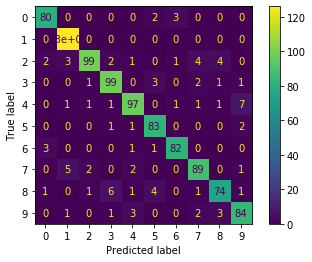

In [22]:
y_pred = small_knn.predict(x_test[:1000])
evaluation_report(small_knn, x_test[:1000], y_test[:1000], y_pred)

#### Training the KNN again, this time with 7 clusters

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.77it/s]


K-NN: n=10 fits resulted in a mean fit time of 0.12682156562805175s
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        85
           1       0.93      1.00      0.97       126
           2       0.96      0.84      0.90       116
           3       0.93      0.93      0.93       107
           4       0.94      0.88      0.91       110
           5       0.88      0.97      0.92        87
           6       0.93      0.94      0.94        87
           7       0.90      0.91      0.90        99
           8       0.89      0.84      0.87        89
           9       0.87      0.90      0.89        94

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



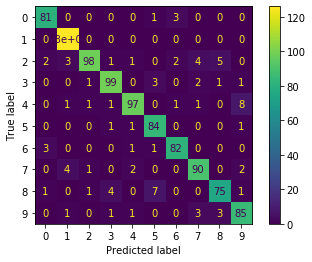

In [25]:
K7_knn = knn_timed_fit(template_x, template_y, n_attempts=10, K=7)
y_pred = K7_knn.predict(x_test[:1000])
evaluation_report(K7_knn, x_test[:1000], y_test[:1000], y_pred)